In [1]:
# ! pip install numpy >> /dev/null
# ! pip install pandas >> /dev/null
# ! pip install opencv-python >> /dev/null
# ! pip install scipy >> /dev/null
# ! pip install torch >> /dev/null
# ! pip install matplotlib >> /dev/null
# ! pip install git+https://github.com/NVlabs/nvdiffrast >> /dev/null

# %pip install pyyaml

In [2]:
import torch
assert torch.cuda.is_available()


import os
import numpy as np
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt
import math

from tqdm import tqdm

from meshwarp import MeshWarper

from scipy.ndimage import gaussian_filter
from scipy.spatial.transform import Rotation



##### Download camera paramethers

In [3]:
import yaml

CAMERA = 0
downloaded_params = None

with open("camchain-calibration-equidistant4_camimu_dataset-calib-imu1.yaml") as stream:
    try:
        downloaded_params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        raise Exception("Hello!")


In [4]:
INPUT_DIR = "./dataset-seq1/mav0/" # replace with your sequence
ORIGINAL_VIDEONAME = "output_orig.mp4"
UNDISTORTED_VIDEONAME = "output_undist.mp4"
RS_REMOVED_VIDEONAME = "output_nors.mp4"
STABILIZED_VIDEONAME = "output_stable_nors.mp4"


# camera params
FPS = 20

# camera intrinsics
pin_hole_model = downloaded_params[f"cam{CAMERA}"]["intrinsics"]
K = np.array([[pin_hole_model[0], 0, pin_hole_model[2]], 
              [0, pin_hole_model[1], pin_hole_model[3]],
              [0, 0, 1]])

# output camera intrinsics
K_new = K.copy()

# distortion params
D = np.array(downloaded_params[f"cam{CAMERA}"]["distortion_coeffs"])

# rotation from imu-to-camera
R_cam_imu = np.array(downloaded_params[f"cam{CAMERA}"]["T_cam_imu"])

# time delta between 2 sensor rows sensing 
dt_rs = 29.47 * 10 ** -6 # in seconds

# frame dimensions
W, H = 1280, 1024

imu_data = pd.read_csv( os.path.join(INPUT_DIR, "imu0", "data.csv") )

print(R_cam_imu)
display(imu_data.head())


[[-0.00596386 -0.99995481  0.00740384  0.05250868]
 [-0.99996281  0.00600971  0.00618561  0.0077584 ]
 [-0.00622983 -0.00736667 -0.99995346 -0.04241051]
 [ 0.          0.          0.          1.        ]]


,#timestamp [ns],w_RS_S_x [rad s^-1],w_RS_S_y [rad s^-1],w_RS_S_z [rad s^-1],a_RS_S_x [m s^-2],a_RS_S_y [m s^-2],a_RS_S_z [m s^-2]
0,1548685763025874686,-0.002432,-0.065141,0.034544,9.771024,0.261885,0.673369
1,1548685763030854686,-0.000729,-0.062837,0.036407,9.756672,0.263069,0.655980
2,1548685763035832686,0.000956,-0.056201,0.036655,9.731556,0.285870,0.636388
3,1548685763040812686,0.001438,-0.050730,0.038257,9.777004,0.275111,0.659217
4,1548685763045791686,0.002640,-0.044960,0.038511,9.755476,0.264269,0.619655


In [5]:
def get_imu_freq_to_camera_fps(imu_data, FPS):
    imu_data = imu_data.head(2).values.tolist()
    t1 = imu_data[0][0]
    t2 = imu_data[1][0]
    return int((1000 / FPS) / (math.ceil((t2 - t1) * 1e-6)))

IMU_MEAS_TO_CAM_MEAS = get_imu_freq_to_camera_fps(imu_data, FPS)
IMU_MEAS_TO_CAM_MEAS  ## Number of gyro measurements per 1 frame

10

In [6]:
def frames_to_video(frames, output_video, fps=20, isColor=False):
    """
    Create a video from a list of frames.

    :param frames: list of frames
    :param output_video: output video file name (e.g., 'output.mp4')
    :param fps: frames per second (default=20)
    """
    if len(frames) == 0:
        raise ValueError("No frames provided")

    # Use the first frame to get dimensions
    height, width, *channels = frames[0].shape

    # Define video writer (using mp4v codec)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video, fourcc, fps, (width, height), isColor=isColor)

    for frame in tqdm(frames, desc="Writing frames to video: "):
        video.write(frame)
        

frames_paths = sorted(glob.glob(os.path.join(INPUT_DIR, "cam1/data/*.png")))
print(f"Number of frames in the video: {len(frames_paths)}")

frames = [cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE) for frame_path in frames_paths]
# frames_to_video(frames, ORIGINAL_VIDEONAME, FPS)

Number of frames in the video: 808


### Homework 2

Given input video from camera with rolling shutter, implement and apply the following algorithms:

    - radial distortion correction (use cv2.fisheye module)
    - rolling shutter correction
    - video stabilization

Expected output of the homework:

    - Jupyter notebook with working code that we can run in real-time
    - plots of camera orientations in time for unstabilized and stabilized motion [plot individual x/y/z components in axis-angle representation]
    - plots of input/output meshgrids for the video frame, where angular velocity has the biggest norm
    - 4 videos stacked together with their frames side-by-side:
        - original
        - undistorted 
        - undistorted + rolling shutter corrected
        - undistorted + rolling shutter corrected + stabilized

Note:
Dataset used in homework provides two sources of camera orientations: IMU (Gyro) measurements of angular velocity and Motion Capture direct measurements of orientation. You should use IMU (Gyro) measurements and implement angular velocity integration. You can use Motion Capture direct measurements of orientation to verify that your integration is implemented correctly.

Rolling shutter correction algorithm is based on this paper: [Digital Video Stabilization and Rolling Shutter Correction using Gyroscopes](https://graphics.stanford.edu/papers/stabilization/).

Dataset: [Rolling-Shutter Visual-Inertial Odometry Dataset](https://cvg.cit.tum.de/data/datasets/rolling-shutter-dataset)

Calibrated camera params can be found [here](https://cdn3.vision.in.tum.de/rolling/calibration/camchain-calibration-equidistant4_camimu_dataset-calib-imu1.yaml)

![Camera Set-up](https://cvg.cit.tum.de/_media/data/datasets/rolling-shutter-dataset/sensor_axes_rgb.jpg?w=800&tok=fa3d4a)

In [7]:
def cv2_imshow(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

### Undistort the video using **cv2 fisheye module**

In [8]:
def undistort_frame(frame, K, D, W, H):
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, (W, H), cv2.CV_16SC2)
    undistorted_img = cv2.remap(frame, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    return undistorted_img


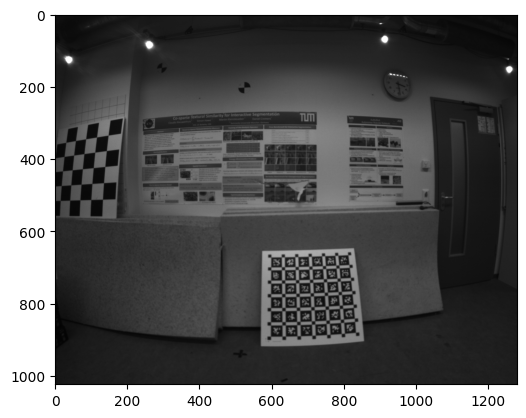

In [9]:
cv2_imshow(frames[0])

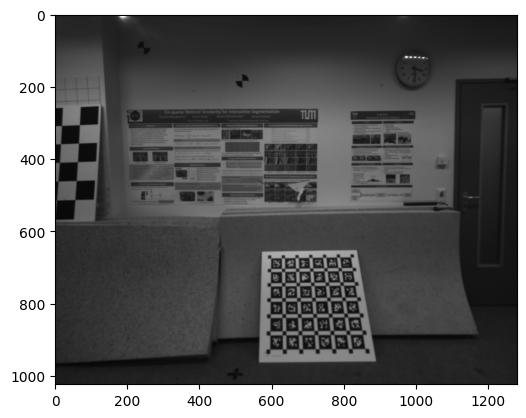

In [10]:
cv2_imshow(undistort_frame(frames[0], K, D, W, H))

##### Correct **Rolling shutter** effect

In [11]:
...

Ellipsis

##### Correct **Motion jitter** effect

###### In order to do that:
 - Take only valid needed imu timestamps (HZ mozna i beZ togo)
 - Integrate over the motion of imu
 - Project onto the smoother(low-pass filtering AKA: Gaussian) logical image motion
 

In [12]:
def get_valid_imu_timeseries(input_dir:str, dt_rs:float):
    ...


In [13]:
import numpy as np
from scipy.spatial.transform import Rotation
from scipy.ndimage import gaussian_filter1d
import numpy as np
from copy import copy

def q_multiply(q1, q2):
    """
    Multiplies two quaternions q1 and q2.
    Quaternions are represented as (x, y, z, w) tuples.
    """
    x1, y1, z1, w1 = q1
    x2, y2, z2, w2 = q2

    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    
    return (x, y, z, w)

def normalize(q):
    norm = math.sqrt(sum(x**2 for x in q))
    return tuple(i / norm for i in q)

def integrate_ang_vel(avx, avy, avz, dt):
    """
    https://stackoverflow.com/questions/24197182/efficient-quaternion-angular-velocity/24201879#24201879
    in (x, y, z, w) form
    """
    length = math.sqrt(avx * avx + avy * avy + avz * avz)
    theta = length * dt * 0.5

    if (length > 1e-12):
        w = math.cos(theta)
        s = math.sin(theta) / length
        return (avx * s, avy * s, avz * s, w)

    return (0, 0, 0, 1)

def imu_to_quaternion_sequence(imu_data):
    timestamps = imu_data["#timestamp [ns]"].to_numpy() * 1e-9
    w_x = imu_data["w_RS_S_x [rad s^-1]"].to_numpy()
    w_y = imu_data["w_RS_S_y [rad s^-1]"].to_numpy()
    w_z = imu_data["w_RS_S_z [rad s^-1]"].to_numpy()

    q = (0.0, 0.0, 0.0, 1.0)  ## identity quaternion
    quats = [copy(q)]

    for i in range(1, len(imu_data)):
        dt = timestamps[i] - timestamps[i - 1]
        av_x, av_y, av_z = w_x[i], w_y[i], w_z[i]
        q_i = integrate_ang_vel(av_x, av_y, av_z, dt)
        # q_i *= np.linalg.norm(q_i)
        q_i = normalize(q_i)
        
        q = q_multiply(q, q_i)  ## not commutative!
        
        quats.append(copy(q))

    return quats

def fix_quaternion_signs(quaternions):
    q_fixed = [quaternions[0]]
    for i in range(1, len(quaternions)):
        prev = q_fixed[-1]
        curr = quaternions[i]
        # Flip sign if dot product < 0
        if np.dot(prev, curr) < 0:
            curr = tuple(-i for i in curr)
        q_fixed.append(curr)
    return q_fixed

# def smooth_motion(quaternions, sigma):
#     """
#     For this plane Gaussian smoothing (yes, that could be done more efficiently)
#     """

from scipy.spatial.transform import Rotation as R
from scipy.ndimage import uniform_filter1d

from scipy.spatial.transform import Slerp

def smooth_quaternions(quaternions, window_size):
    # quaternions = fix_quaternion_signs(quaternions)
    sigma = 10
    
    rotvecs = R.from_quat(quaternions).as_rotvec()
    print(f"{rotvecs[1] = }")
    print(f"{rotvecs[2] = }")
    
    rot_x = pd.Series([i[0] for i in rotvecs])
    rot_y = pd.Series([i[1] for i in rotvecs])
    rot_z = pd.Series([i[2] for i in rotvecs])
    
    # rot_x_smooth = gaussian_filter(rot_x, sigma=sigma)
    # rot_y_smooth = gaussian_filter(rot_y, sigma=sigma)
    # rot_z_smooth = gaussian_filter(rot_z, sigma=sigma)

    rot_x_smooth = rot_x.ewm(alpha=0.1, adjust=False).mean()
    rot_y_smooth = rot_y.ewm(alpha=0.1, adjust=False).mean()
    rot_z_smooth = rot_z.ewm(alpha=0.1, adjust=False).mean()

    rotvec_smooth = np.stack([rot_x_smooth, rot_y_smooth, rot_z_smooth], axis=1)
    
    
    # smoothed = uniform_filter1d(rotvecs, size=window_size, axis=0, mode='nearest')
    
    q_smooth = R.from_rotvec(rotvec_smooth).as_quat()
    return q_smooth



def homogenize(pts):
    return np.concatenate([pts, np.ones((pts.shape[0], 1), dtype=pts.dtype)], axis=1)

warper = MeshWarper()

def project_frames(in_frame, quat_orig, quat_smoothed, K, R_cam_imu):
    
    r = Rotation.from_quat(quat_orig)
    R_i = r.as_matrix()
    
    r = Rotation.from_quat(quat_smoothed)
    R_j = r.as_matrix()
    
    homo = K @ R_j @ R_i.T @ np.linalg.inv(K)
    
    # # grid_homo = homogenize(grid_src)      # Nx3
    # # grid_dst_homo = (H @ grid_homo.T).T   # Nx3
    # # grid_dst = grid_dst_homo[:, :2] / grid_dst_homo[:, 2:]   # divide by w
    # return cv2.warpPerspective(in_frame, homo, (W, H))
    
    
    grid_src, faces = warper.build_meshgrid(W, H, grid_rows=32, grid_cols=32)


    verts_h = np.concatenate([grid_src, np.ones((grid_src.shape[0], 1))], axis=1).T  # 3xN

    # Compute homography from IMU+camera rotation
    verts_dst_h = (homo @ verts_h).T
    verts_dst = verts_dst_h[:, :2] / verts_dst_h[:, 2:3]
    
    warped_frame = warper.warp_grid(
        image=in_frame,
        grid_src=grid_src,
        grid_dst=verts_dst,
        faces=faces,
        output_shape=(W, H)
    )
    return warped_frame


W1015 13:39:10.352000 10503 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1015 13:39:10.352000 10503 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


CUDA device available. Using cuda:0 for warping.


RuntimeError: Error building extension 'nvdiffrast_plugin': [1/6] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output RasterImpl.cuda.o.d -DTORCH_EXTENSION_NAME=nvdiffrast_plugin -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /home/julfy/.local/lib/python3.10/site-packages/nvidia/cudnn/include -isystem /usr/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -DNVDR_TORCH -lineinfo -std=c++17 -c /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/nvdiffrast/common/cudaraster/impl/RasterImpl.cu -o RasterImpl.cuda.o 
[31mFAILED: [code=1] [0mRasterImpl.cuda.o 
/usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output RasterImpl.cuda.o.d -DTORCH_EXTENSION_NAME=nvdiffrast_plugin -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /home/julfy/.local/lib/python3.10/site-packages/nvidia/cudnn/include -isystem /usr/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -DNVDR_TORCH -lineinfo -std=c++17 -c /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/nvdiffrast/common/cudaraster/impl/RasterImpl.cu -o RasterImpl.cuda.o 
In file included from /usr/local/cuda/include/cuda_runtime.h:83,
                 from <command-line>:
/usr/local/cuda/include/crt/host_config.h:132:2: error: #error -- unsupported GNU version! gcc versions later than 11 are not supported! The nvcc flag '-allow-unsupported-compiler' can be used to override this version check; however, using an unsupported host compiler may cause compilation failure or incorrect run time execution. Use at your own risk.
  132 | #error -- unsupported GNU version! gcc versions later than 11 are not supported! The nvcc flag '-allow-unsupported-compiler' can be used to override this version check; however, using an unsupported host compiler may cause compilation failure or incorrect run time execution. Use at your own risk.
      |  ^~~~~
[2/6] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output rasterize.cuda.o.d -DTORCH_EXTENSION_NAME=nvdiffrast_plugin -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /home/julfy/.local/lib/python3.10/site-packages/nvidia/cudnn/include -isystem /usr/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -DNVDR_TORCH -lineinfo -std=c++17 -c /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/nvdiffrast/common/rasterize.cu -o rasterize.cuda.o 
[31mFAILED: [code=1] [0mrasterize.cuda.o 
/usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output rasterize.cuda.o.d -DTORCH_EXTENSION_NAME=nvdiffrast_plugin -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /home/julfy/.local/lib/python3.10/site-packages/nvidia/cudnn/include -isystem /usr/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -DNVDR_TORCH -lineinfo -std=c++17 -c /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/nvdiffrast/common/rasterize.cu -o rasterize.cuda.o 
In file included from /usr/local/cuda/include/cuda_runtime.h:83,
                 from <command-line>:
/usr/local/cuda/include/crt/host_config.h:132:2: error: #error -- unsupported GNU version! gcc versions later than 11 are not supported! The nvcc flag '-allow-unsupported-compiler' can be used to override this version check; however, using an unsupported host compiler may cause compilation failure or incorrect run time execution. Use at your own risk.
  132 | #error -- unsupported GNU version! gcc versions later than 11 are not supported! The nvcc flag '-allow-unsupported-compiler' can be used to override this version check; however, using an unsupported host compiler may cause compilation failure or incorrect run time execution. Use at your own risk.
      |  ^~~~~
[3/6] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output interpolate.cuda.o.d -DTORCH_EXTENSION_NAME=nvdiffrast_plugin -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /home/julfy/.local/lib/python3.10/site-packages/nvidia/cudnn/include -isystem /usr/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -DNVDR_TORCH -lineinfo -std=c++17 -c /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/nvdiffrast/common/interpolate.cu -o interpolate.cuda.o 
[31mFAILED: [code=1] [0minterpolate.cuda.o 
/usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output interpolate.cuda.o.d -DTORCH_EXTENSION_NAME=nvdiffrast_plugin -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /home/julfy/.local/lib/python3.10/site-packages/nvidia/cudnn/include -isystem /usr/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -DNVDR_TORCH -lineinfo -std=c++17 -c /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/nvdiffrast/common/interpolate.cu -o interpolate.cuda.o 
In file included from /usr/local/cuda/include/cuda_runtime.h:83,
                 from <command-line>:
/usr/local/cuda/include/crt/host_config.h:132:2: error: #error -- unsupported GNU version! gcc versions later than 11 are not supported! The nvcc flag '-allow-unsupported-compiler' can be used to override this version check; however, using an unsupported host compiler may cause compilation failure or incorrect run time execution. Use at your own risk.
  132 | #error -- unsupported GNU version! gcc versions later than 11 are not supported! The nvcc flag '-allow-unsupported-compiler' can be used to override this version check; however, using an unsupported host compiler may cause compilation failure or incorrect run time execution. Use at your own risk.
      |  ^~~~~
[4/6] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output texture.cuda.o.d -DTORCH_EXTENSION_NAME=nvdiffrast_plugin -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /home/julfy/.local/lib/python3.10/site-packages/nvidia/cudnn/include -isystem /usr/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -DNVDR_TORCH -lineinfo -std=c++17 -c /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/nvdiffrast/common/texture.cu -o texture.cuda.o 
[31mFAILED: [code=1] [0mtexture.cuda.o 
/usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output texture.cuda.o.d -DTORCH_EXTENSION_NAME=nvdiffrast_plugin -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /home/julfy/.local/lib/python3.10/site-packages/nvidia/cudnn/include -isystem /usr/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -DNVDR_TORCH -lineinfo -std=c++17 -c /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/nvdiffrast/common/texture.cu -o texture.cuda.o 
In file included from /usr/local/cuda/include/cuda_runtime.h:83,
                 from <command-line>:
/usr/local/cuda/include/crt/host_config.h:132:2: error: #error -- unsupported GNU version! gcc versions later than 11 are not supported! The nvcc flag '-allow-unsupported-compiler' can be used to override this version check; however, using an unsupported host compiler may cause compilation failure or incorrect run time execution. Use at your own risk.
  132 | #error -- unsupported GNU version! gcc versions later than 11 are not supported! The nvcc flag '-allow-unsupported-compiler' can be used to override this version check; however, using an unsupported host compiler may cause compilation failure or incorrect run time execution. Use at your own risk.
      |  ^~~~~
[5/6] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output antialias.cuda.o.d -DTORCH_EXTENSION_NAME=nvdiffrast_plugin -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /home/julfy/.local/lib/python3.10/site-packages/nvidia/cudnn/include -isystem /usr/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -DNVDR_TORCH -lineinfo -std=c++17 -c /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/nvdiffrast/common/antialias.cu -o antialias.cuda.o 
[31mFAILED: [code=1] [0mantialias.cuda.o 
/usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output antialias.cuda.o.d -DTORCH_EXTENSION_NAME=nvdiffrast_plugin -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include -isystem /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /home/julfy/.local/lib/python3.10/site-packages/nvidia/cudnn/include -isystem /usr/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -DNVDR_TORCH -lineinfo -std=c++17 -c /home/julfy/Documents/5th_term/cv/.venv_hw2/lib/python3.12/site-packages/nvdiffrast/common/antialias.cu -o antialias.cuda.o 
In file included from /usr/local/cuda/include/cuda_runtime.h:83,
                 from <command-line>:
/usr/local/cuda/include/crt/host_config.h:132:2: error: #error -- unsupported GNU version! gcc versions later than 11 are not supported! The nvcc flag '-allow-unsupported-compiler' can be used to override this version check; however, using an unsupported host compiler may cause compilation failure or incorrect run time execution. Use at your own risk.
  132 | #error -- unsupported GNU version! gcc versions later than 11 are not supported! The nvcc flag '-allow-unsupported-compiler' can be used to override this version check; however, using an unsupported host compiler may cause compilation failure or incorrect run time execution. Use at your own risk.
      |  ^~~~~
ninja: build stopped: subcommand failed.


In [ ]:


def correct_motion(in_frames, imu_data, R_cam_imu, IMU_MEAS_TO_CAM_MEAS ,K):
    sigma=20
    # print(f"{R_cam_imu = }")
    # display(imu_data.head())
    # print(f"{len(imu_data) = }")
    # print(f"{len(in_frames) = }")

    quaternions = imu_to_quaternion_sequence(imu_data)  ## it has abs rotation at timeframe \t

    print(f"{quaternions[500] = }")
    
    quaternions_smoothed = smooth_quaternions(quaternions, 75)
    
    print(f"{quaternions_smoothed[500] = }")
    
    # from scipy.spatial.transform import Slerp

    # key_times = np.arange(len(quaternions))
    # slerp = Slerp(key_times, R.from_quat(quaternions))
    # new_times = np.linspace(0, len(quaternions)-1, len(quaternions))
    # smoothed_rots = slerp(new_times)

    # rotvec = Rotation.from_quat(quaternions).as_rotvec()
    # rot_x = [i[0] for i in rotvec]
    # rot_y = [i[1] for i in rotvec]
    # rot_z = [i[2] for i in rotvec]

    # rot_x_smooth = gaussian_filter(rot_x, sigma=sigma)
    # rot_y_smooth = gaussian_filter(rot_y, sigma=sigma)
    # rot_z_smooth = gaussian_filter(rot_z, sigma=sigma)

    # rotvec_smooth = np.stack([rot_x_smooth, rot_y_smooth, rot_z_smooth], axis=1)  # shape (N, 3)

    # # convert back to quaternions
    # quats_smooth = Rotation.from_rotvec(rotvec_smooth).as_quat()

    # print(quats_smooth[10])

    # print(f"{rotvec_smooth = }")
    
    
    
    
    # import csv

    # filename = "quaternions.csv"

    # # Open the CSV file in write mode ('w') with newline=''
    # # newline='' is crucial to prevent extra blank rows in the CSV file

    # # data = np.concat([quaternions, quaternions_smoothed], axis=1)
    # data = [str(quaternions[i]) + "\t|||\t" + str(quaternions_smoothed[i]) + "\n" for i in range(len(quaternions))]
    # print(f"{data = }")

    # with open(filename, 'w', newline='') as csvfile:
    #     # Create a csv.writer object
    #     csv_writer = csv.writer(csvfile)

    #     # Write the data to the CSV file
    #     # If you have a header row, write it first
    #     # csv_writer.writerow(data[0]) # Uncomment if you have a separate header row

    #     # Write the rest of the data (or all data if no separate header)
    #     csv_writer.writerow("Original\t|||\tSmoothed")
    #     csv_writer.writerow(data)

    # print(f"Data successfully written to {filename}")
        
    
    
    
    projected_frames = []

    for idx, frame in enumerate(in_frames):
        projected_frames.append(project_frames(frame, quaternions[idx * IMU_MEAS_TO_CAM_MEAS], quaternions_smoothed[idx * IMU_MEAS_TO_CAM_MEAS], K, R_cam_imu))
        # projected_frames.append(project_frames(frame, quaternions[idx * IMU_MEAS_TO_CAM_MEAS], quaternions[idx * IMU_MEAS_TO_CAM_MEAS], K))
    # print(f"{len(quaternions) = }")
    # print(f"{len(smoothed_rots) = }")

    # for idx, frame in enumerate(in_frames):
    #     print(f"{smoothed_rots[idx * IMU_MEAS_TO_CAM_MEAS] = }")
    #     projected_frames.append(project_frames_slerp(frame, quaternions[idx * IMU_MEAS_TO_CAM_MEAS], smoothed_rots[idx * IMU_MEAS_TO_CAM_MEAS], K))
        # projected_frames.append(project_frames(frame, quaternions[idx * IMU_MEAS_TO_CAM_MEAS], quaternions[idx * IMU_MEAS_TO_CAM_MEAS], K))

    

    return projected_frames


smoothed_frames = correct_motion(frames, imu_data, R_cam_imu, IMU_MEAS_TO_CAM_MEAS, K)


In [ ]:
import cv2
import numpy as np

def save_side_by_side_video_with_labels_gray(frames_left, frames_right, output_path, fps=30,
                                             label_left="Left", label_right="Right"):
    if len(frames_left) == 0 or len(frames_right) == 0:
        raise ValueError("Input frame lists must not be empty.")

    num_frames = min(len(frames_left), len(frames_right))
    h1, w1 = frames_left[0].shape[:2]

    def resize_to_height(img, target_h):
        h, w = img.shape[:2]
        scale = target_h / h
        new_w = int(w * scale)
        return cv2.resize(img, (new_w, target_h))

    # Prepare VideoWriter
    sample_right = resize_to_height(frames_right[0], h1)
    h2, w2 = sample_right.shape[:2]
    out_w = w1 + w2
    out_h = h1

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(output_path, fourcc, fps, (out_w, out_h))

    # Font settings
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.0
    color = (0, 255, 0)  # green
    thickness = 2
    margin = 10

    for i in range(num_frames):
        left = frames_left[i].copy()
        right = resize_to_height(frames_right[i], h1)

        # Convert grayscale to BGR
        if len(left.shape) == 2:
            left = cv2.cvtColor(left, cv2.COLOR_GRAY2BGR)
        if len(right.shape) == 2:
            right = cv2.cvtColor(right, cv2.COLOR_GRAY2BGR)

        # Draw text labels
        cv2.putText(left, label_left, (margin, 30), font, font_scale, color, thickness, cv2.LINE_AA)
        cv2.putText(right, label_right, (margin, 30), font, font_scale, color, thickness, cv2.LINE_AA)

        combined = np.hstack((left, right))
        writer.write(combined)

    writer.release()
    print(f"Saved side-by-side video to {output_path}")


In [ ]:
smoothed_video_name = "EMW a=0.1, MESHWARP"

save_side_by_side_video_with_labels_gray(
    frames, smoothed_frames, 
    "output_with_labels.mp4", fps=FPS,
    label_left="Original", label_right=smoothed_video_name
)

frames_to_video(smoothed_frames, smoothed_video_name + ".mp4", FPS)


In [ ]:
def create_difference_video(frames1, frames2, output_path, fps=30):
    """
    Create a video from the difference of two lists of grayscale frames.

    Parameters:
        frames1 (list[np.ndarray]): First list of grayscale frames (H x W).
        frames2 (list[np.ndarray]): Second list of grayscale frames (same size as frames1).
        output_path (str): Path to save the resulting video (e.g., 'output.avi').
        fps (int): Frames per second for the output video.
    """
    # Check lists
    if len(frames1) != len(frames2):
        raise ValueError("Both frame lists must have the same length.")
    if len(frames1) == 0:
        raise ValueError("Frame lists are empty.")

    # Get frame dimensions
    height, width = frames1[0].shape

    # Define video writer
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # or 'mp4v' for .mp4 output
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=False)

    for f1, f2 in zip(frames1, frames2):
        # Ensure both frames are np.uint8 grayscale
        if f1.shape != f2.shape:
            raise ValueError("Frames must have the same shape.")
        if f1.dtype != np.uint8:
            f1 = cv2.normalize(f1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        if f2.dtype != np.uint8:
            f2 = cv2.normalize(f2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Compute absolute difference
        diff = f1 - f2
        # assert f1.all() == f2.all()

        # Write frame to video
        out.write(diff)

    out.release()
    print(f"Video saved to {output_path}")


In [ ]:
create_difference_video(frames, smoothed_frames, "output_difference_MA_w75.mp4", fps=FPS)

In [ ]:

def plot_axis_motion(imu_data, IMU_MEAS_TO_CAM_MEAS):
    sigma = 100
    # plt.figure(figsize=(15, 5))

    # plt.plot(imu_data["w_RS_S_x [rad s^-1]"], label="X rotation", color="blue")
    # plt.plot(imu_data["w_RS_S_y [rad s^-1]"], label="Y rotation", color="red")
    # plt.plot(imu_data["w_RS_S_z [rad s^-1]"], label="Z rotation", color="green")

    # plt.legend()
    # plt.show()
    
    # filtered_x_sigmal_my = [gaussian_filter(i, sigma) for i in imu_data["w_RS_S_x [rad s^-1]"]]
    filtered_x_sigmal_my = [gaussian_filter([imu_data["w_RS_S_x [rad s^-1]"][i - 1], imu_data["w_RS_S_x [rad s^-1]"][i]], sigma) for i in range(1, len(imu_data["w_RS_S_x [rad s^-1]"]))]
    # print(f"{filtered_x_sigmal_my = }")
    filtered_x_signal = gaussian_filter(imu_data["w_RS_S_x [rad s^-1]"], sigma=sigma)
    plt.figure(figsize=(15, 5))

    plt.plot(imu_data["w_RS_S_x [rad s^-1]"], label="X rotation", color="blue")
    plt.plot(filtered_x_signal, label="X rotation(G. low-pass filter) scipy", color="red")
    plt.plot(filtered_x_sigmal_my, label="X rotation(G. low-pass filter) my", color="orange")

    # plt.plot(imu_data["w_RS_S_y [rad s^-1]"], label="Y rotation", color="red")
    # plt.plot(imu_data["w_RS_S_z [rad s^-1]"], label="Z rotation", color="green")

    plt.legend()
    plt.show()
    
    

# plot_axis_motion(imu_data, IMU_MEAS_TO_CAM_MEAS)